Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


TypeError: 'float' object is not iterable

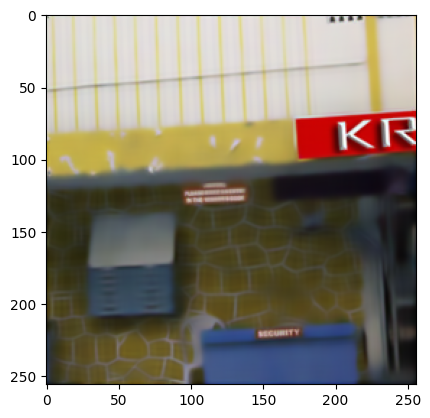

In [14]:
import cv2 as cv 
import numpy as np
import matplotlib.pyplot as plt


"""
    calculate_gaussian Function

    Calculates the Gaussian similarity between two vectors.

    Parameters:
    - V_p: First vector.
    - V_q: Second vector.
    - sigma: Standard deviation of the Gaussian function (default=1.0).

    Returns:
    - similarity: Gaussian similarity between the two vectors.
    """

def calculate_gaussian(V_p, V_q ,sigma = 1.0):
    
    diff = np.linalg.norm(V_p - V_q)
    return np.exp(-diff**2 / (2 * sigma**2))

########

"""
    nlm_filter Function

    Applies non-local means filtering to an image.

    Parameters:
    - image: Input image array.
    - W:  size of the search window
    - W_sim: size of the similarity window
    - sigma: Standard deviation for Gaussian 

    Returns:
    - filtered_image: NLM Filtered image.
    """

def nlm_filter(image, W, W_sim, sigma):
    pad_size = W + W_sim
    padded_image = np.pad(image, ((pad_size, pad_size), (pad_size, pad_size), (0, 0)), 'constant', constant_values=0)
    filtered_image = np.zeros_like(image)
    for channel in range(3):
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                weights = []
                img_patch = []
                m, n = i + pad_size, j + pad_size
                p = padded_image[m - W_sim:m + W_sim + 1, n - W_sim:n + W_sim + 1, channel]
                p = p.flatten()
                for x in range(m - W, m + W + 1):
                    for y in range(n - W, n + W + 1):
                        q = padded_image[x - W_sim:x + W_sim + 1, y - W_sim:y + W_sim + 1, channel]
                        q = q.flatten()
                        index = len(q) // 2
                        q_ = q[index]
                        gaussian = calculate_gaussian(p, q, sigma)
                        weights.append(gaussian)
                        img_patch.append(q_)
                weights = weights / np.sum(weights)
                filtered_image[i, j, channel] = np.sum(np.dot(weights, img_patch))
    plt.imshow(filtered_image)
    return filtered_image

##########


"""
    PSNR Function
    Calculates the Peak Signal-to-Noise Ratio (PSNR) between two images.

    Parameters:
    - f: Original image array.
    - f_hat: Filtered image array.

    Returns:
    - psnr: PSNR value.
    """

def PSNR(f,f_hat):
    MSE=np.average((f-f_hat)**2)
    max1=f.max()
    return 10*np.log10((max1*max1)/MSE)

#######

"""
    make_kernel Function

    Generates a Gaussian kernel.

    Parameters:
    - sigma: Standard deviation of the Gaussian function.

    Returns:
    - gaussian_filter: Gaussian kernel.
    """


def make_kernel(sigma):
    k = int(np.ceil(6 * sigma))
    if k % 2 == 0:  # If k is even, make it odd by adding 1
        k += 1
    k_mid = k // 2
    gaussian_filter = np.zeros((k, k), np.float32)
    for y in range(-k_mid, k_mid + 1):
        for x in range(-k_mid, k_mid + 1):
            normal = 1 / (2 * np.pi * sigma**2)
            exp_term = np.exp(-(x**2 + y**2) / (2 * sigma**2))
            gaussian_filter[y + k_mid, x + k_mid] = normal * exp_term
    gaussian_filter = gaussian_filter / np.sum(gaussian_filter)  # to normalize the gaussian filter
    return gaussian_filter

#########

"""
    pad Function

    Pads an image with zeros based on the given sigma value.

    Parameters:
    - sigma: Standard deviation of the Gaussian function.
    - image: Input image array.

    Returns:
    - output_image: Padded image array.
    """


def pad(sigma, image):
    h, w = image.shape[:2]
    k = int(np.ceil(6 * sigma) + 1)
    output_image = np.zeros((h, w, 3), dtype=np.float32)
    output_image = np.pad(image, ((int((k - 1) / 2), int((k - 1) / 2)), 
                                  (int((k - 1) / 2), int((k - 1) / 2)), 
                                  (0, 0)), 'constant')
    return output_image



"""
    convolution Function

    Performs convolution on an image using a Gaussian kernel.

    Parameters:
    - img: Input image array.
    - sigma: Standard deviation of the Gaussian function.

    Returns:
    - conv_image: Convolved image.
"""

##########

def convolution(img, sigma):
    
    kernel = make_kernel(sigma)
    pad = kernel.shape[0] // 2
    padded_image = np.zeros((img.shape[0] + 2 * pad, img.shape[1] + 2 * pad, 3))
    padded_image[pad:img.shape[0] + pad, pad:img.shape[1] + pad, :] = img
    conv_image = np.zeros((img.shape[0], img.shape[1], 3))
    for c in range(0, 3):
        for m in range(img.shape[0]):
            for n in range(img.shape[1]):
                i = m + pad
                j = n + pad
                img_bit = padded_image[i - pad:i + pad + 1, j - pad:j + pad + 1, c]
                cov = np.sum(img_bit * kernel)
                conv_image[m, n, c] = cov
    plt.imshow(conv_image)
    return conv_image


krishna_g = cv.imread("/home/gadha/Desktop/Courses/ISP_2024/lab_10/krishna_0_001.png")
krishna_f = cv.imread("/home/gadha/Desktop/Courses/ISP_2024/lab_10/krishna.png")

# Convert the image to floating point format and normalize intensity range to [0, 1]
g = krishna_g.astype(float) / 255.0  #noisy image
f = krishna_f.astype(float) / 255.0  #actual image

# Q1 parameters
sigma_values = [0.1, 0.2, 0.3, 0.4, 0.5]
W1 = 3
W2 = 5
W_sim = 3 #similarity window size
Images_1 = []
Images_2 = []
PSNR_1 = []
PSNR_2 = []
baseline_psnr = PSNR(f, g)
baseline_plot = np.ones(5) * baseline_psnr

# Q1 
for sigma in sigma_values:   
    filter_img1 = nlm_filter(g, W1, W_sim, sigma)
    filter_img2 = nlm_filter(g, W2, W_sim, sigma)
    Images_1.append(filter_img1)
    Images_2.append(filter_img2)
    psnr_1 = PSNR(f, filter_img1)
    psnr_2 = PSNR(f, filter_img2)
    PSNR_1.append(psnr_1)
    PSNR_2.append(psnr_2)

PSNR_gaussian = []
image_gaussian = []

# Q2 
for sig in sigma:
    Kernel = make_kernel(sig)
    convol_image = convolution(g, sig)
    psnr = PSNR(f, convol_image)
    image_gaussian.append(convol_image)
    PSNR_gaussian.append(psnr)

# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(sigma_values, PSNR_1, label='W=3 & Wsim=3')
plt.plot(sigma_values, PSNR_2, label='W=5 & Wsim=3')
plt.plot(sigma_values, baseline_plot, label='baseline')
plt.title('Q1: NLM Filter PSNR')
plt.xlabel('Sigma')
plt.ylabel('PSNR')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(sigma, PSNR_gaussian, label='Gaussian Blur')
plt.title('Q2: Gaussian Blur PSNR')
plt.xlabel('Sigma')
plt.ylabel('PSNR')
plt.legend()

plt.show()


In [11]:
""" 
   generate_kernel Function
    Generates a Gaussian kernel with a specified size.

    Parameters:
    - sigma: Standard deviation of the Gaussian function.
    - size: Size of the kernel.

    Returns:
    - kernel: Gaussian kernel.

"""


def generate_kernel(sigma, size):
    size = int(size)
    kernel = np.zeros((size, size))
    half_size = size // 2
    if sigma == 0:
        return np.array([1])
    for row in range(-half_size, half_size + 1):
        for col in range(-half_size, half_size + 1):
            part1 = np.pi * 2 * (sigma ** 2)
            distance = (row ** 2 + col ** 2) / (2 * sigma ** 2)
            part2 = np.exp(-distance)
            kernel[row + half_size, col + half_size] = part2 / part1
    kernel = kernel / np.sum(kernel)
    return kernel

In [12]:
"""
    gaussian_similarity Function
    
    Calculates the Gaussian similarity between two image patches.

    Parameters:
    - patch1: First image patch array.
    - patch2: Second image patch array.
    - sigma: Standard deviation of the Gaussian function.

    Returns:
    - similarity: Gaussian similarity between the two

"""


def gaussian_similarity(patch1, patch2, sigma):
    squared_diff = np.sum((patch1 - patch2) ** 2)
    similarity = np.exp(-squared_diff / (2 * sigma ** 2))
    return similarity

In [7]:
""" 
    nlm_kernel Function
    Generates a non-local means kernel for a specific pixel location in an image.

    Parameters:
    - image: Input image array.
    - window_size: Half size of the search window.
    - window_similarity: Half size of the similarity window.
    - sigma: Standard deviation for Gaussian weighting.
    - row: Row index of the pixel.
    - col: Column index of the pixel.

    Returns:
    - kernel_matrix: Non-local means kernel matrix.
    """


def nlm_kernel(image, window_size, window_similarity, sigma, row, col):
    # Initialize the kernel matrix
    kernel_matrix = np.zeros((2 * window_size + 1, 2 * window_size + 1, 3))
    
    # row and column ranges for the patch
    row_start, row_end = row - window_size, row + window_size
    col_start, col_end = col - window_size, col + window_size
    
    for channel in range(3):
        # extracting central patch and flattening it
        central_patch = image[row - window_similarity:row + window_similarity + 1,
                               col - window_similarity:col + window_similarity + 1, channel]
        central_patch = central_patch.flatten()
        
        kernel_row = 0
        
        for i in range(row_start, row_end + 1):
            kernel_col = 0
            
            for j in range(col_start, col_end + 1):
                # extracting neighbour patch and flattening it
                neighbor_patch = image[i - window_similarity:i + window_similarity + 1,
                                       j - window_similarity:j + window_similarity + 1, channel]
                neighbor_patch = neighbor_patch.flatten()
                
                # similarity between the patches
                similarity = gaussian_similarity(central_patch, neighbor_patch, sigma)
                
                kernel_matrix[kernel_row, kernel_col, channel] = similarity     # Update the kernel matrix
                kernel_col += 1
            kernel_row += 1
        
        kernel_matrix[:, :, channel] /= np.sum(kernel_matrix[:, :, channel])
    
    return kernel_matrix


Text(0.5, 1.0, 'NLM kernel at (38,58)')

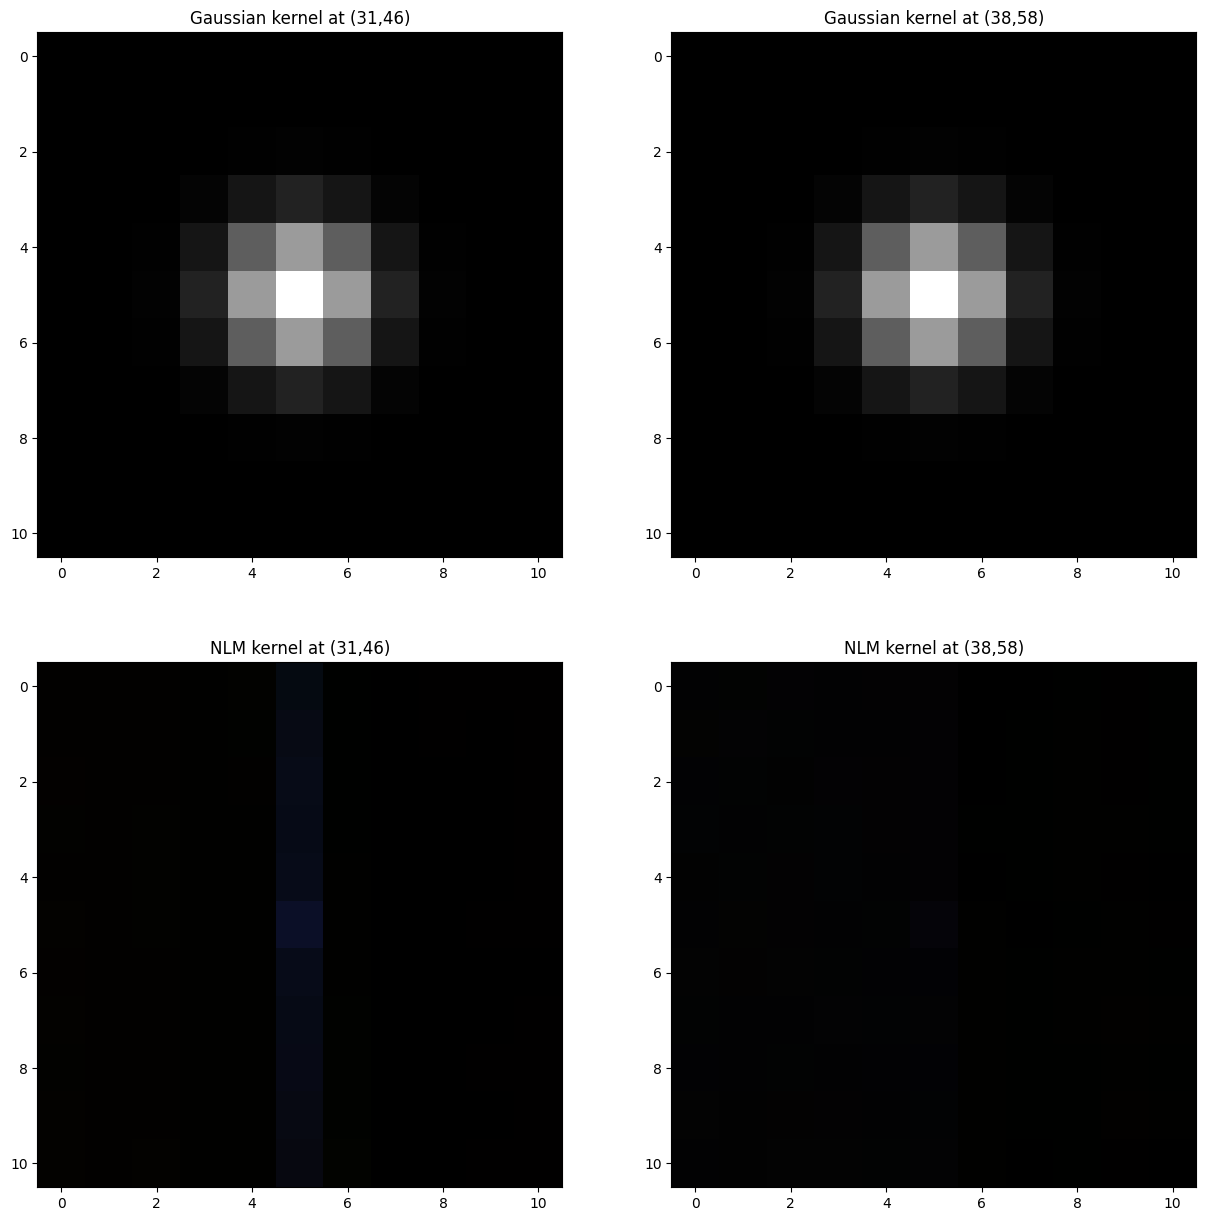

In [13]:
plt.figure(0,figsize=(15,15))
plt.subplot(221)
size=11
Kernel2=generate_kernel(1,size)
plt.imshow(Kernel2,cmap='gray')
plt.title('Gaussian kernel at (31,46)')

plt.subplot(222)

size=11
Kernel2=generate_kernel(1,size)
plt.imshow(Kernel2,cmap='gray')
plt.title('Gaussian kernel at (38,58)')

plt.subplot(223)
kernel1=nlm_kernel(g,5,3,.3,31,46)
plt.imshow(kernel1)
plt.title('NLM kernel at (31,46)')

plt.subplot(224)
kernel1=nlm_kernel(g,5,3,.3,38,58)
plt.imshow(kernel1)
plt.title('NLM kernel at (38,58)')



Text(0.5, 1.0, 'Gaussian Filtered image at (31,46)')

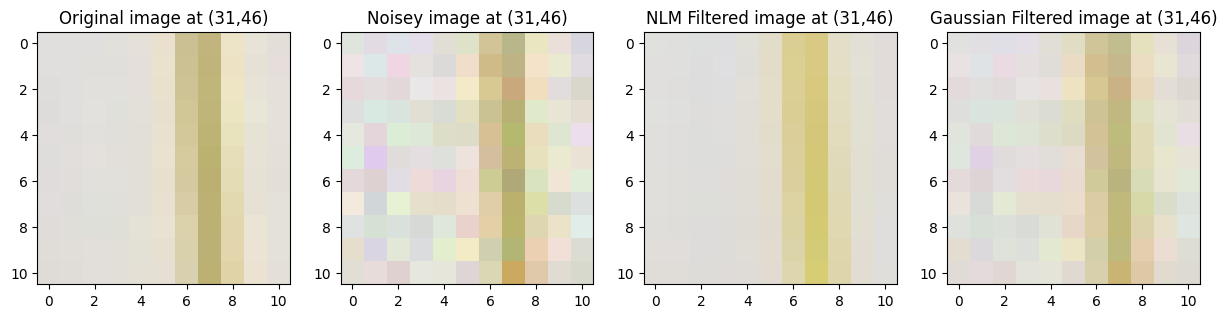

In [9]:
plt.figure(0,figsize=(15,15))
plt.subplot(141)
plt.imshow(f[31-5:31+5+1,46-5:46+5+1,:])
plt.title('Original image at (31,46)')

plt.subplot(142)
plt.imshow(g[31-5:31+5+1,46-5:46+5+1,:])
plt.title('Noisy image at (31,46)')
plt.subplot(143)
plt.imshow(Images_2[2][31-5:31+5+1,46-5:46+5+1,:])
plt.title('NLM Filtered image at (31,46)')

plt.subplot(144)
plt.imshow(image_gaussian[4][31-5:31+5+1,46-5:46+5+1,:])
plt.title('Gaussian Filtered image at (31,46)')

Text(0.5, 1.0, 'Gaussian Filtered image at (38,58)')

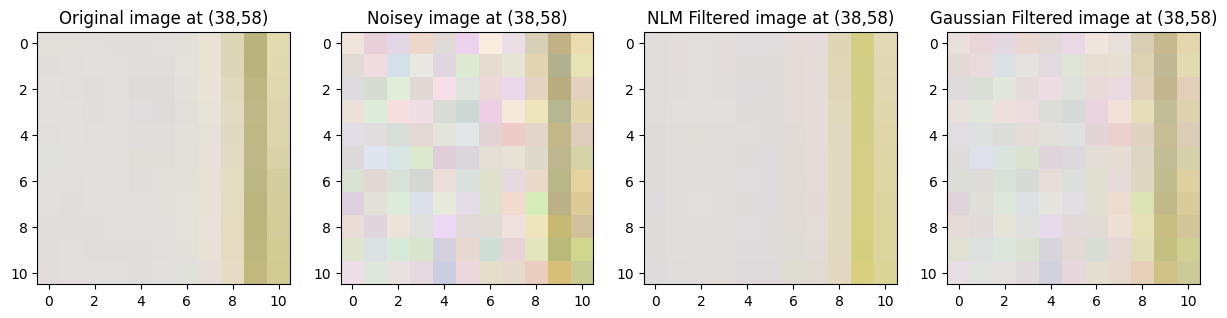

In [10]:
plt.figure(0,figsize=(15,15))
plt.subplot(141)
plt.imshow(f[38-5:38+5+1,58-5:58+5+1,:])
plt.title('Original image at (38,58)')

plt.subplot(142)
plt.imshow(g[38-5:38+5+1,58-5:58+5+1,:])
plt.title('Noisy image at (38,58)')

plt.subplot(143)
plt.imshow(Images_2[2][38-5:38+5+1,58-5:58+5+1,:])
plt.title('NLM Filtered image at (38,58)')


plt.subplot(144)
plt.imshow(image_gaussian[4][38-5:38+5+1,58-5:58+5+1,:])
plt.title('Gaussian Filtered image at (38,58)')